# Polyps segmentation on Colonoscopy Images

__Author: Fernandez Hernandez, Alberto__

__Date: 2022-02-18__

## Data available:
1. CVC-Clinic DB: 612 sequential WL images with polyps extracted from 31 sequences with 31 different polyps.

![CVC-Clinic sample](https://rumc-gcorg-p-public.s3.amazonaws.com/f/challenge/57/42e07411-ee60-4396-9969-063253427356/gtcvc1.png)

2. ETIS-Larib: 196 WL images with polyps extracted from 34 sequences with 44 different polyps.

![ETIS-Larib sample](https://rumc-gcorg-p-public.s3.amazonaws.com/f/challenge/57/b1e244b1-5b01-4a4c-b9d6-2d96fe615c1c/gtetislarib2.png)

3. Kvasir-SEG: 1000 polyp images.

![Kvasir-SEG sample](https://production-media.paperswithcode.com/datasets/Screenshot_2021-02-01_at_20.51.15.png)

 | Dataset name | Resolution | Type |
 |--------------|------------|------------|
 | [CVC-ClinicDB](https://polyp.grand-challenge.org/CVCClinicDB/) | 388x324    | Colonoscopy
 | [ETIS-Larib](https://polyp.grand-challenge.org/EtisLarib/)   | 1225x966   | Colonoscopy |
 | [Kvasir-SEG](https://datasets.simula.no/kvasir-seg/)  | From 332x487 to 1920x1072 pixels   | Colonoscopy |

In [29]:
# Updating albumentation library + Install pretrained UNet seg. library
!pip install --upgrade albumentations
!pip install segmentation-models-pytorch
!pip install opencv-python-headless==4.5.2.52

In [30]:
# -- Libraries
from   prettytable                 import PrettyTable   # -- Table beautifier
from   tqdm                        import tqdm          # -- Progress bar
from   tensorflow.keras            import backend as K  # -- Keras backend
import segmentation_models_pytorch as smp               # -- Pretrained UNet seg. models
import torchvision.models          as models            # -- Pretrained pytorch models
import matplotlib.pyplot           as plt               # -- Graphics library
import albumentations              as album             # -- Image augmentation library
import tqdm.notebook               as tq                # -- Progress bar fixed
import tensorflow                  as tf                # -- Deep learning framework
import pandas                      as pd                # -- Data manipulation
import numpy                       as np                # -- Numeric operations
import tifffile                    as tiff              # -- Tiff read images library
import torch.nn                    as nn                # -- Deep learning library (I)
import torch                                            # -- Deep learning library (II)
import warnings                                         # -- Clear all warning messages
import random                                           # -- Native python library$
import glob                                             # -- Filesystem access (I) 
import cv2                                              # -- Computer vision library 
import sys                                              # -- System library
import os                                               # -- Filesystem access (II)

warnings.filterwarnings("ignore")

In [31]:
# -- Constants
TRAIN_DIR            = '/content/drive/MyDrive/Personal/Polyps_Segmentation/data/Kvasir-SEG/'
VAL_DIR              = '/content/drive/MyDrive/Personal/Polyps_Segmentation/data/ETIS-LaribPolypDB/'
TEST_DIR             = '/content/drive/MyDrive/Personal/Polyps_Segmentation/data/CVC-ClinicDB/'
MODEL_PATH           = '/content/drive/MyDrive/Personal/Polyps_Segmentation/models/unet_polyps_seg_model.pth'
REAL_TIME_MODEL_PATH = '/content/drive/MyDrive/Personal/Polyps_Segmentation/models/regseg_polyps_real_time_seg_model.pth'
ENCODER              = 'resnet18'
ENCODER_WEIGHTS      = 'imagenet'
ACTIVATION           = 'sigmoid'
CLASS_NAMES          = ['polyp', 'background']
CLASS_RGB_VALUES     = [[255, 255, 255], [0, 0, 0]]
IMG_DIM              = [224, 224]
EPOCHS               = 15
LR                   = 1e-04
DEVICE               = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SELECT_CLASS_IND     = [CLASS_NAMES.index(cls.lower()) for cls in CLASS_NAMES]
SELECT_CLASS_RGB     =  np.array(CLASS_RGB_VALUES)[SELECT_CLASS_IND]

## Define Data Loader class

### Aditional functions

In [32]:
## Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x
  
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [33]:
class EndoscopyDataset(torch.utils.data.Dataset):
    """Kvasir-SEG Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            path,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = os.listdir(path + 'images')
        self.mask_paths  = os.listdir(path + 'masks')
        self.path        = path
        self.image_paths.sort()
        self.mask_paths.sort()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation     = augmentation
        self.preprocessing    = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        if '.tif' not in self.image_paths[i]:
          image = cv2.cvtColor(cv2.imread(self.path + 'images/' + self.image_paths[i]), 
                               cv2.COLOR_BGR2RGB)
          mask  = cv2.cvtColor(cv2.imread(self.path + 'masks/' + self.mask_paths[i]), 
                               cv2.COLOR_BGR2RGB)
        else:
          image = tiff.imread(self.path + 'images/' + self.image_paths[i])
          mask  = tiff.imread(self.path + 'masks/' + self.mask_paths[i])
          mask  = np.stack((mask,)*3, axis=-1)
          
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

### Train dir example (Kvasir dataset)

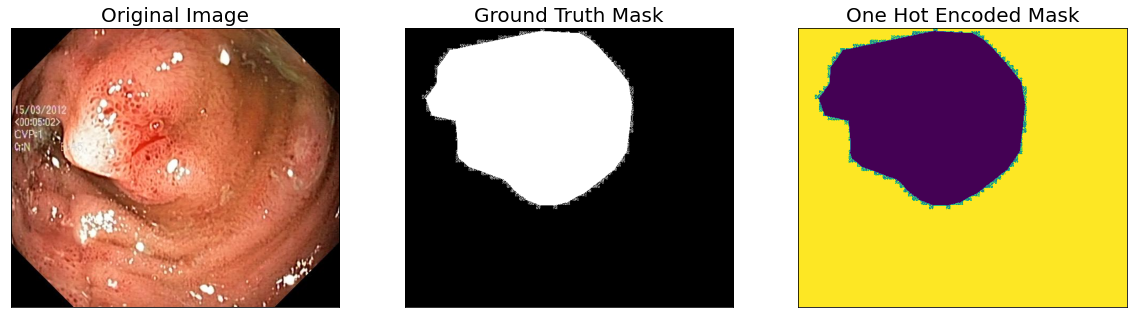

In [ ]:
dataset     = EndoscopyDataset(TRAIN_DIR, class_rgb_values=SELECT_CLASS_RGB)
image, mask = dataset[0]

visualize(
    original_image       = image,
    ground_truth_mask    = colour_code_segmentation(reverse_one_hot(mask), SELECT_CLASS_RGB),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Val dir example (ETIS-LaribPolypDB dataset)

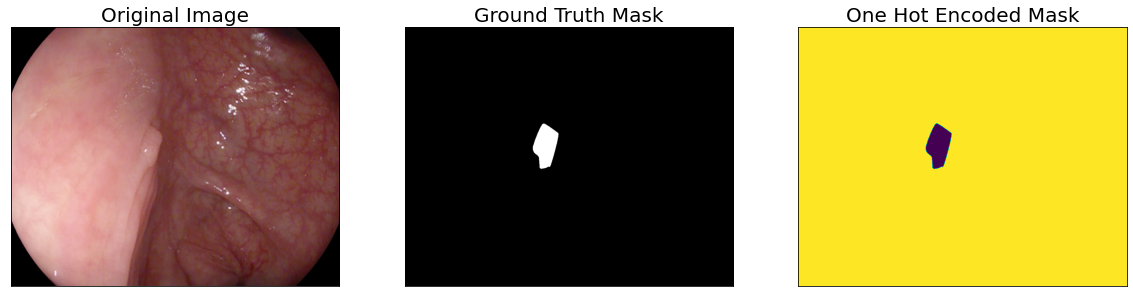

In [ ]:
dataset     = EndoscopyDataset(VAL_DIR, class_rgb_values=SELECT_CLASS_RGB)
image, mask = dataset[0]

visualize(
    original_image       = image,
    ground_truth_mask    = colour_code_segmentation(reverse_one_hot(mask), SELECT_CLASS_RGB),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Test dir example (CVC-ClinicDB dataset)

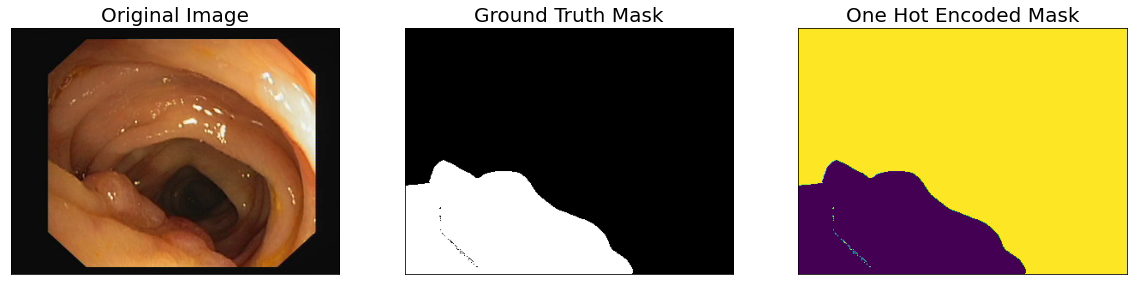

In [ ]:
dataset     = EndoscopyDataset(TEST_DIR, class_rgb_values=SELECT_CLASS_RGB)
image, mask = dataset[0]

visualize(
    original_image       = image,
    ground_truth_mask    = colour_code_segmentation(reverse_one_hot(mask), SELECT_CLASS_RGB),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

## Data augmentation definition

In [6]:
def get_training_augmentation():
    train_transform = [
        album.Resize(height=512, width=608, interpolation=cv2.INTER_CUBIC, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_test_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.Resize(height=512, width=608, interpolation=cv2.INTER_CUBIC, always_apply=True),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

## UNet model definition

![UNet model architecture](https://www.researchgate.net/profile/Alan-Jackson-2/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [ ]:
# -- Create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASS_NAMES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

## Define train and validation loaders

In [ ]:
# Get train, val and test dataset instances
train_dataset = EndoscopyDataset(
    TRAIN_DIR, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=SELECT_CLASS_RGB
)

valid_dataset = EndoscopyDataset(
    VAL_DIR, 
    augmentation=get_validation_test_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=SELECT_CLASS_RGB
)

test_dataset = EndoscopyDataset(
    TEST_DIR, 
    augmentation=get_validation_test_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=SELECT_CLASS_RGB
)

# Get train and val data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

## Setup hyperparameters

![Intersection over union metric (IoU)](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)

In [ ]:
# -- Loss function
loss = smp.utils.losses.DiceLoss()

# -- IoU metric (Intersection over Union)
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# -- Optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LR),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

## Train model

In [ ]:
best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []

for i in range(0, EPOCHS):
    # -- Perform training & validation
    print('\nEpoch: {}'.format(i))
    print("Training...")
    train_logs = train_epoch.run(train_loader)
    print("Validation...")
    valid_logs = valid_epoch.run(valid_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)

    # -- Save model if a better val IoU score is obtained
    if best_iou_score < valid_logs['iou_score']:
      print("IOU Score has improved from {} to {}".format(best_iou_score, valid_logs['iou_score']))
      print('Saving model...')
      best_iou_score = valid_logs['iou_score']
      torch.save(model, MODEL_PATH)
    else:
      print("IOU Score has not improved")


Epoch: 0
Training...
train: 100%|██████████| 63/63 [02:20<00:00,  2.23s/it, dice_loss - 0.3343, iou_score - 0.7199]
Validation...
valid: 100%|██████████| 13/13 [00:30<00:00,  2.35s/it, dice_loss - 0.2634, iou_score - 0.8547]
IOU Score has improved from 0.0 to 0.85466946546848
Saving model...

Epoch: 1
Training...
train: 100%|██████████| 63/63 [02:15<00:00,  2.15s/it, dice_loss - 0.2338, iou_score - 0.8754]
Validation...
valid: 100%|██████████| 13/13 [00:28<00:00,  2.23s/it, dice_loss - 0.1844, iou_score - 0.9288]
IOU Score has improved from 0.85466946546848 to 0.9288270244231591
Saving model...

Epoch: 2
Training...
train: 100%|██████████| 63/63 [02:15<00:00,  2.14s/it, dice_loss - 0.1771, iou_score - 0.903]
Validation...
valid: 100%|██████████| 13/13 [00:28<00:00,  2.20s/it, dice_loss - 0.147, iou_score - 0.948]
IOU Score has improved from 0.9288270244231591 to 0.9480240207452039
Saving model...

Epoch: 3
Training...
train: 100%|██████████| 63/63 [02:14<00:00,  2.13s/it, dice_loss - 

In [ ]:
# -- Clean cache
torch.cuda.empty_cache()

# Test phase

In [ ]:
model = torch.load(MODEL_PATH)

In [ ]:
# -- Perform testing
valid_logs = valid_epoch.run(test_loader)
# -- Save model if a better val IoU score is obtained
print("iou_score: " + str(valid_logs['iou_score']))

valid: 100%|██████████| 39/39 [01:35<00:00,  2.46s/it, dice_loss - 0.05267, iou_score - 0.922]
iou_score: 0.9219926458138684


### Prediction samples + Heatmap

In [34]:
def scale_to_0_255(img):
  img_numpy = img
  return ((img_numpy - img_numpy.min()) * (1/(img_numpy.max() - img_numpy.min()) * 255)).astype('uint8')

Image #0


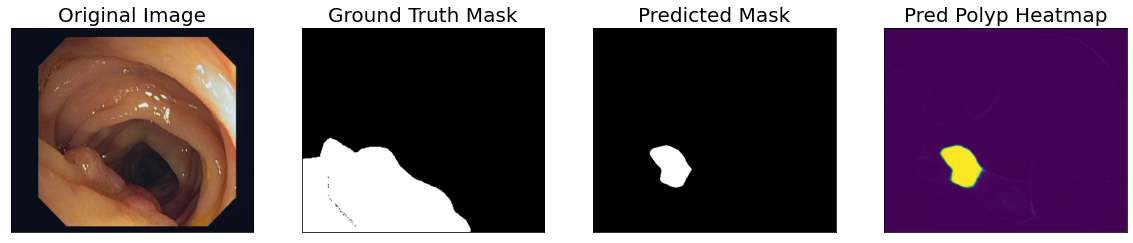

Image #1


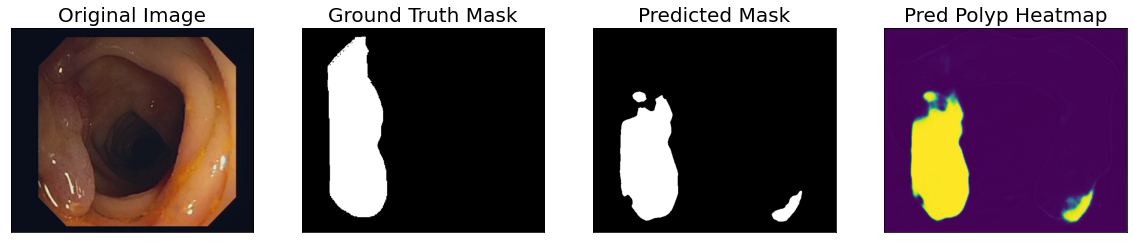

Image #2


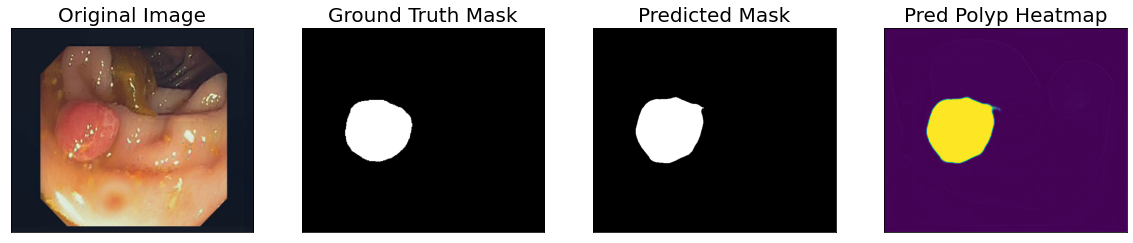

Image #3


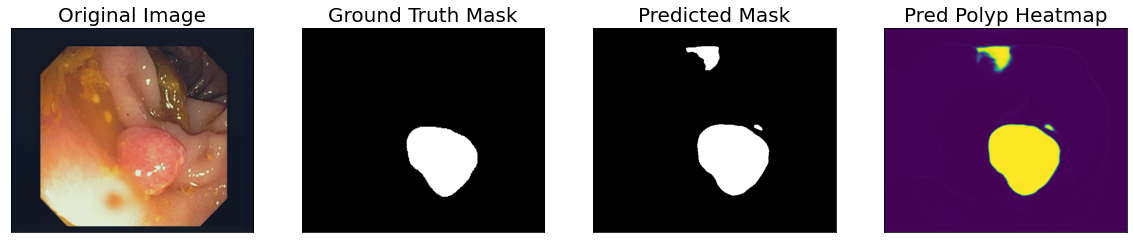

Image #4


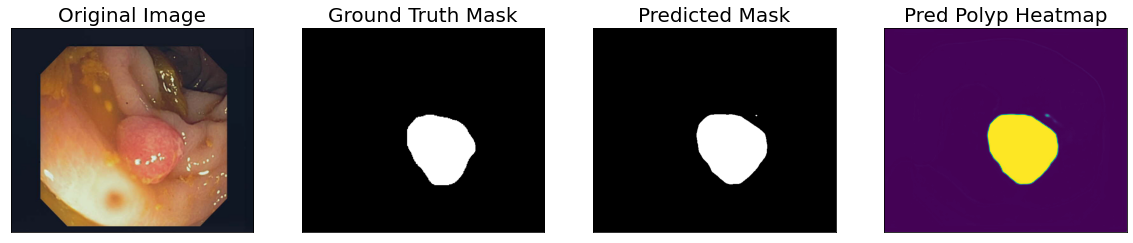

Image #5


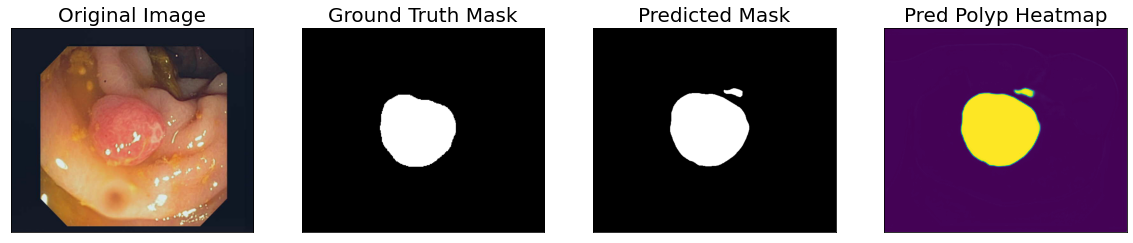

Image #6


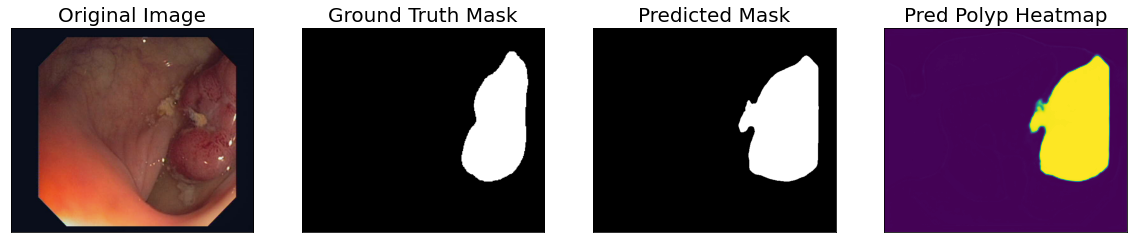

Image #7


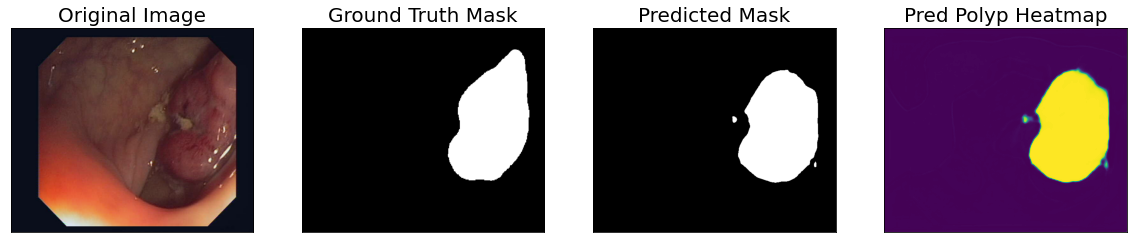

Image #8


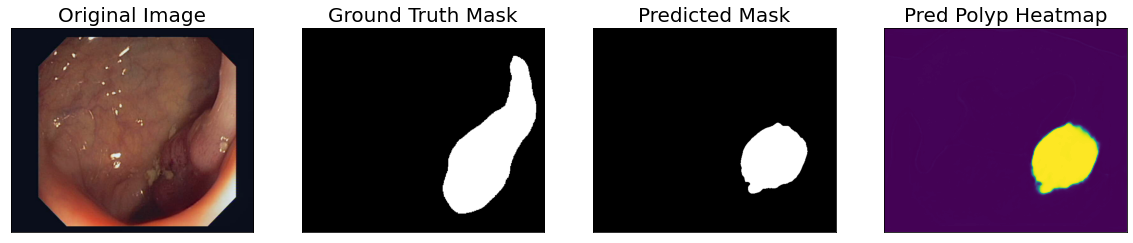

Image #9


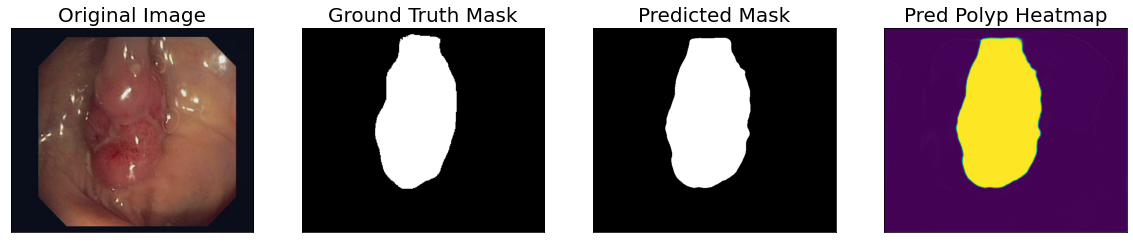

In [ ]:
for idx in range(len(test_dataset)):
    if idx < 10:
      print("Image #{}".format(idx))
      image, gt_mask = test_dataset[idx]
      image_vis      = test_dataset[idx][0].astype('uint8')

      input_tensor   = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
      # Predict test image
      pred_mask = model(input_tensor)
      pred_mask = pred_mask.detach().squeeze().cpu().numpy()
      # Convert pred_mask from `CHW` format to `HWC` format
      pred_mask = np.transpose(pred_mask,(1,2,0))
      # Get prediction channel corresponding to foreground
      pred_polyp_heatmap = pred_mask[:,:,0]
      pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), CLASS_RGB_VALUES)
      # Convert gt_mask from `CHW` format to `HWC` format
      gt_mask = np.transpose(gt_mask,(1,2,0))
      gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), CLASS_RGB_VALUES)
      
      visualize(
          original_image = scale_to_0_255(np.moveaxis(image, 0, -1)),
          ground_truth_mask = gt_mask,
          predicted_mask = pred_mask,
          pred_polyp_heatmap = pred_polyp_heatmap
      )

# Real Time Segmentation phase with Keras
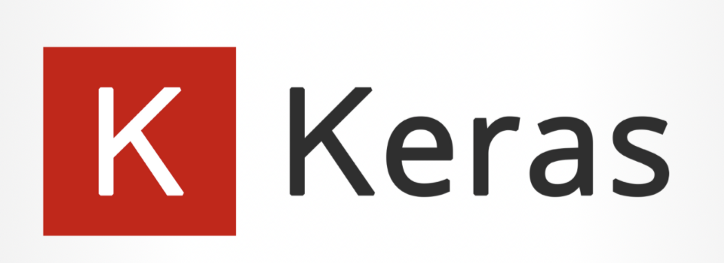)

## References
__Tensorflow documentation__: https://www.tensorflow.org/tutorials/images/segmentation

__Google Colab Notebook__: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb#scrollTo=liCeLH0ctjq7

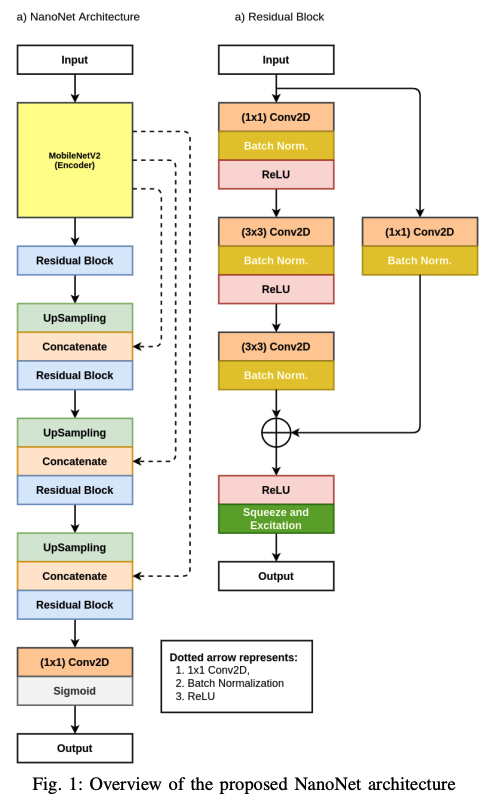

## Download MobileNet_v2 architecture

### Residual block

In [35]:
IMG_DIM = [256, 256]

In [36]:
def residual_block(x, num_filters, ratio=16):
    x_init = x
    x = tf.keras.layers.Conv2D(num_filters//4, (1, 1), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(num_filters//4, (3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(num_filters, (3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # -- Skip connection
    s = tf.keras.layers.Conv2D(num_filters, (1, 1), padding="same")(x_init)
    s = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Add()([x, s])
    x = tf.keras.layers.Activation("relu")(x)

    init = x
    filters = init.shape[-1]
    se_shape = (1, 1, filters)
    
    # -- Squeeze excite block
    se = tf.keras.layers.GlobalAveragePooling2D()(init)
    se = tf.keras.layers.Reshape(se_shape)(se)
    se = tf.keras.layers.Dense(filters // ratio, activation='relu', 
                               kernel_initializer='he_normal', use_bias=False)(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid', 
                               kernel_initializer='he_normal', use_bias=False)(se)

    x  = tf.keras.layers.Multiply()([init, se])
    return x

### NanoNet architecture

In [ ]:
tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, alpha=1).summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                

In [54]:
def NanoNet(input_shape=(256,256,3), encoder_layer_name="block_6_expand_relu"):
    inputs  = tf.keras.layers.Input(shape=input_shape, name="input_image")

    # -- Encoder layer
    encoder = tf.keras.applications.MobileNetV2(input_tensor=inputs, input_shape=input_shape,
                                                weights="imagenet", include_top=False, alpha=1)
    encoder_output = encoder.get_layer(name=encoder_layer_name).output
    skip_connections_name = ["input_image", "block_1_expand_relu", "block_3_expand_relu"]

    # -- Create residual block
    # -- 1x1 Conv2D -> 3x3 Conv2D -> 3x3 Conv2D + 1x1 Conv2D
    f = [32, 64, 128]
    x = residual_block(encoder_output, 192)

    # -- Decoder layer
    for i in range(1, len(skip_connections_name)+1, 1):
        x_skip = encoder.get_layer(skip_connections_name[-i]).output
        x_skip = tf.keras.layers.Conv2D(f[-i], (1, 1), padding="same")(x_skip)
        x_skip = tf.keras.layers.BatchNormalization()(x_skip)
        x_skip = tf.keras.layers.Activation("relu")(x_skip)

        x = tf.keras.layers.UpSampling2D((2, 2), interpolation='bilinear')(x)

        try:
            x = tf.keras.layers.Concatenate()([x, x_skip])
        except Exception as e:
            x = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)
            x = tf.keras.layers.Concatenate()([x, x_skip])

        x = residual_block(x, f[-i])

    ## Output
    x = tf.keras.layers.Conv2D(1, (1, 1), padding="same")(x)
    x = tf.keras.layers.Activation("sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [55]:
nanonet = NanoNet()

In [56]:
nanonet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [40]:
def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
        album.Rotate(limit=[-15,15]),
        album.Cutout(max_h_size=int(IMG_DIM[0] * 0.3), max_w_size=int(IMG_DIM[1] * 0.3), 
                     num_holes=1, p=0.5),
        album.CLAHE(p=0.5)
    ]
    return album.Compose(train_transform)

In [41]:
class EndoscopyDataset(tf.keras.utils.Sequence):
    """Kvasir-SEG Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            image_paths=None,
            mask_paths=None,
            class_rgb_values=None,
            augmentation=None, 
            batch_size=8,
            dim=(256,256),
            n_channels=3,
            shuffle=False
    ):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        
        self.class_rgb_values = class_rgb_values
        self.augmentation     = augmentation
        self.batch_size       = batch_size
        self.dim              = dim
        self.n_channels       = n_channels
        self.indexes          = np.arange(len(self.image_paths))
        self.shuffle          = shuffle
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, i):
        self.on_epoch_end()
        # Generate indexes on the batch
        indexes = self.indexes[i*self.batch_size:(i+1)*self.batch_size]
        # Output arrays
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim), dtype=int)
        list_index = 0
        for i_aux in indexes:
          # -- Read images and masks
          if '.tif' not in self.image_paths[i_aux]:
            image = cv2.cvtColor(cv2.imread(self.image_paths[i_aux]), 
                                cv2.COLOR_BGR2RGB)
            mask  = cv2.cvtColor(cv2.imread(self.mask_paths[i_aux]), 
                                cv2.COLOR_BGR2RGB)
          else:
            image = tiff.imread(self.image_paths[i_aux])
            mask  = tiff.imread(self.mask_paths[i_aux])
            mask  = np.stack((mask,)*3, axis=-1)
            
          # -- One-hot-encode the mask
          mask  = one_hot_encode(mask, self.class_rgb_values).astype('float')
          
          # -- Apply augmentations
          if self.augmentation:
              sample = self.augmentation(image=image, mask=mask)
              image, mask = sample['image'], sample['mask']

          image = self.__resize_img(n_channels=3, array=image)
          mask  = cv2.resize(mask[:,:,0], self.dim)

          X[list_index,] = image / 255 # Normalize between 0 and 1
          y[list_index]  = mask.astype(np.float32)
          list_index+=1
        return X, y.astype(np.float32)
    def __resize_img(self, n_channels, array):
        img_stack_sm = np.zeros((256, 256, n_channels))

        for idx in range(0, n_channels):
            img    = array[:, :, idx]
            img_sm = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
            img_stack_sm[:, :, idx] = img_sm
        return img_stack_sm

    # -- Shuffle indexes after each epoch
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

### Model compile

In [42]:
# -- Intersection over Union metric (IoU)
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
# -- Dice Loss metric
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [43]:
metrics = [iou]
nanonet.compile(loss=dice_loss, optimizer=tf.keras.optimizers.Adam(LR), metrics=metrics)

In [44]:
images = glob.glob(TRAIN_DIR + '/images/*') + glob.glob(VAL_DIR + '/images/*') + glob.glob(TEST_DIR + '/images/*')
images.sort()

In [45]:
masks  = glob.glob(TRAIN_DIR + '/masks/*') + glob.glob(VAL_DIR + '/masks/*') + glob.glob(TEST_DIR + '/masks/*')
masks.sort()

In [46]:
len(images), len(masks)

(1808, 1808)

In [47]:
images_masks = list(zip(images, masks))

random.Random(1234).shuffle(images_masks)

images, masks = zip(*images_masks)

In [48]:
# -- Train - validation - test split (70/20/10)
train_index  = int(0.7*len(images))
images_train = images[:train_index]
masks_train  = masks[:train_index]

val_index    = int(0.2*len(images))
images_val   = images[train_index:train_index+val_index]
masks_val    = masks[train_index:train_index+val_index]

images_test  = images[train_index+val_index:len(images)]
masks_test   = masks[train_index+val_index:len(images)]

In [49]:
# Get train, val and test dataset instances
train_dataset = EndoscopyDataset(
    image_paths=images_train,
    mask_paths=masks_train,
    augmentation=get_training_augmentation(),
    class_rgb_values=SELECT_CLASS_RGB,
    shuffle=True
)

valid_dataset = EndoscopyDataset(
    image_paths=images_val,
    mask_paths=masks_val,
    augmentation=None, 
    class_rgb_values=SELECT_CLASS_RGB
)

test_dataset = EndoscopyDataset(
    image_paths=images_test,
    mask_paths=masks_test,
    augmentation=None, 
    class_rgb_values=SELECT_CLASS_RGB
)

### Setup callbacks

In [51]:
callbacks = [
        tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Personal/Polyps_Segmentation/models/regseg_polyps_real_time_seg_original_model_deep_model_B.h5', verbose=1, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False, verbose=1),
]

### Training phase

### NanoNet B

In [52]:
# -- Lightweight model
EPOCHS = 100
nanonet.fit_generator(generator=train_dataset,
                      validation_data=valid_dataset,
                      callbacks=callbacks,
                      epochs=EPOCHS,
                      use_multiprocessing=True,
                      workers=6)

Epoch 1/100
158/158 [==============================] - ETA: 0s - loss: 0.6565 - iou: 0.2129
Epoch 1: val_loss improved from inf to 0.76402, saving model to /content/drive/MyDrive/Personal/Polyps_Segmentation/models/regseg_polyps_real_time_seg_original_model_deep_model_B.h5
158/158 [==============================] - 158s 849ms/step - loss: 0.6565 - iou: 0.2129 - val_loss: 0.7640 - val_iou: 0.1351 - lr: 1.0000e-04
Epoch 2/100
158/158 [==============================] - ETA: 0s - loss: 0.4889 - iou: 0.3489
Epoch 2: val_loss improved from 0.76402 to 0.64990, saving model to /content/drive/MyDrive/Personal/Polyps_Segmentation/models/regseg_polyps_real_time_seg_original_model_deep_model_B.h5
158/158 [==============================] - 84s 504ms/step - loss: 0.4889 - iou: 0.3489 - val_loss: 0.6499 - val_iou: 0.2146 - lr: 1.0000e-04
Epoch 3/100
158/158 [==============================] - ETA: 0s - loss: 0.4127 - iou: 0.4206
Epoch 3: val_loss improved from 0.64990 to 0.59661, saving model to /cont

Process Keras_worker_ForkPoolWorker-163:
Process Keras_worker_ForkPoolWorker-167:
Process Keras_worker_ForkPoolWorker-164:
Process Keras_worker_ForkPoolWorker-168:
Process Keras_worker_ForkPoolWorker-165:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-166:
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-p

KeyboardInterrupt: ignored

### NanoNet C

In [ ]:
# -- Lightweight model
EPOCHS = 100
nanonet.fit_generator(generator=train_dataset,
                      validation_data=valid_dataset,
                      callbacks=callbacks,
                      epochs=EPOCHS,
                      use_multiprocessing=True,
                      workers=6)

Epoch 1/100
158/158 [==============================] - ETA: 0s - loss: 0.6543 - iou: 0.2134
Epoch 1: val_loss improved from inf to 0.68076, saving model to /content/drive/MyDrive/Personal/Polyps_Segmentation/models/regseg_polyps_real_time_seg_original_model.h5
158/158 [==============================] - 254s 1s/step - loss: 0.6543 - iou: 0.2134 - val_loss: 0.6808 - val_iou: 0.1923 - lr: 1.0000e-04
Epoch 2/100
158/158 [==============================] - ETA: 0s - loss: 0.5284 - iou: 0.3135
Epoch 2: val_loss improved from 0.68076 to 0.55714, saving model to /content/drive/MyDrive/Personal/Polyps_Segmentation/models/regseg_polyps_real_time_seg_original_model.h5
158/158 [==============================] - 109s 661ms/step - loss: 0.5284 - iou: 0.3135 - val_loss: 0.5571 - val_iou: 0.2872 - lr: 1.0000e-04
Epoch 3/100
158/158 [==============================] - ETA: 0s - loss: 0.4778 - iou: 0.3593
Epoch 3: val_loss improved from 0.55714 to 0.49178, saving model to /content/drive/MyDrive/Personal/P

In [57]:
# -- Load trained model
nanonet = tf.keras.models.load_model('/content/drive/MyDrive/Personal/Polyps_Segmentation/models/regseg_polyps_real_time_seg_original_model.h5',
                                     custom_objects={'dice_loss': dice_loss, 'iou': iou})

Original image # 0


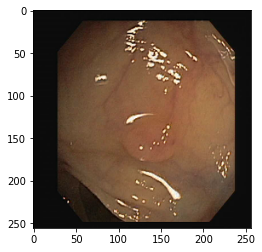

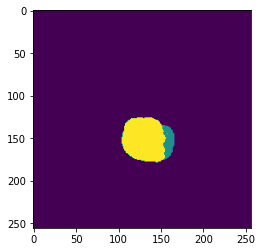

################################################################################
Original image # 1


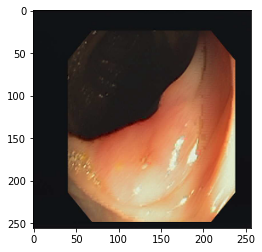

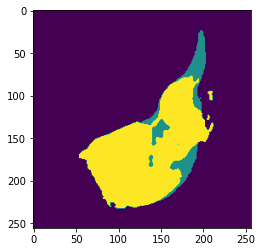

################################################################################
Original image # 2


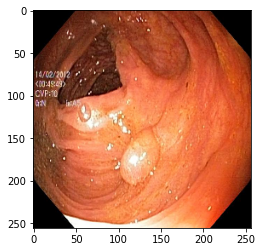

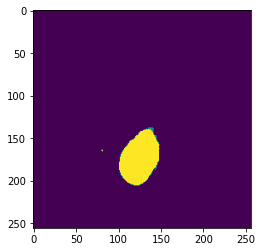

################################################################################
Original image # 3


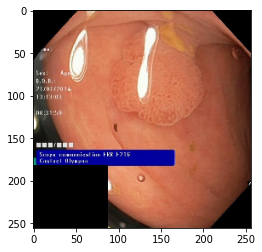

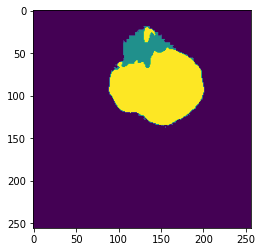

################################################################################
Original image # 4


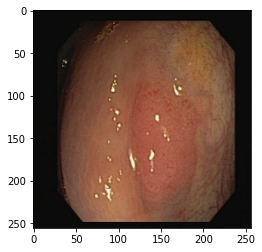

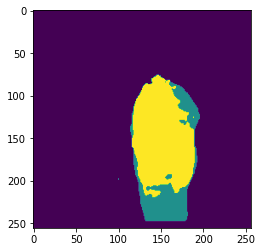

################################################################################
Original image # 5


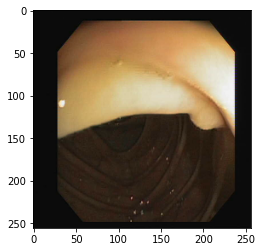

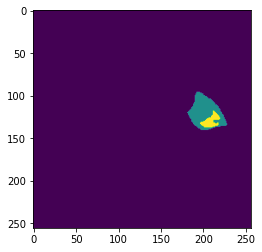

################################################################################
Original image # 6


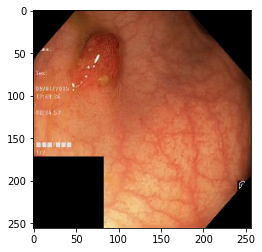

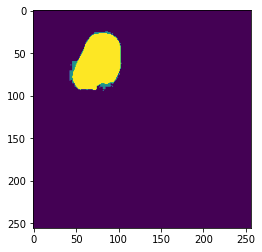

################################################################################
Original image # 7


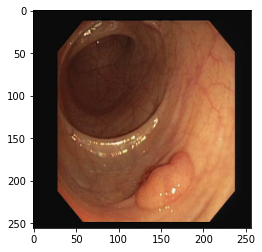

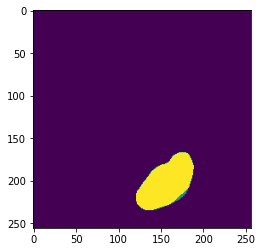

################################################################################
Original image # 0


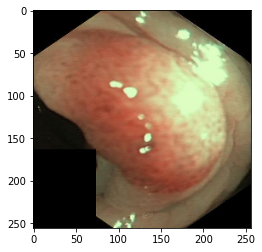

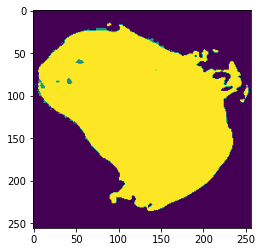

################################################################################
Original image # 1


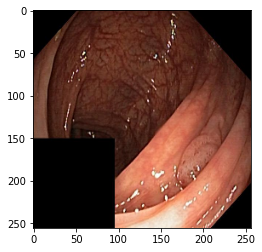

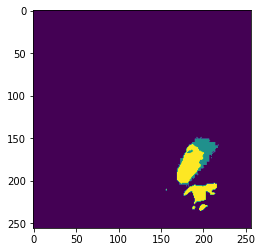

################################################################################
Original image # 2


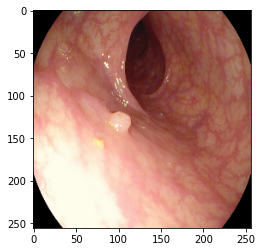

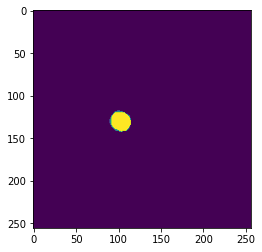

################################################################################
Original image # 3


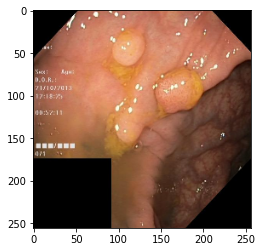

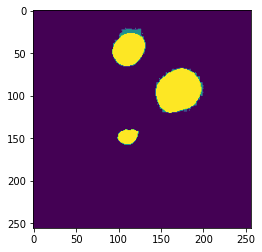

################################################################################
Original image # 4


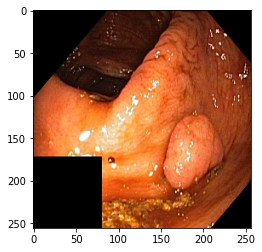

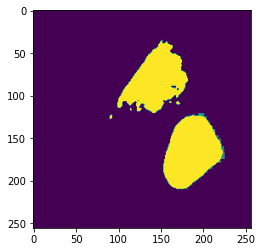

################################################################################
Original image # 5


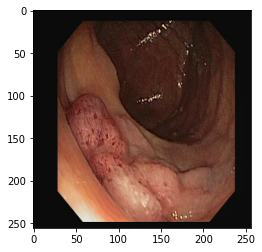

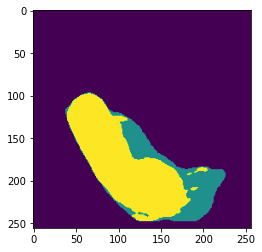

################################################################################
Original image # 6


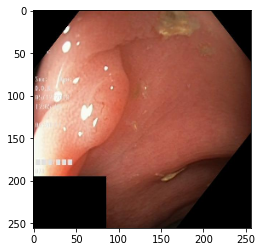

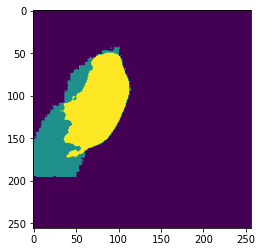

################################################################################
Original image # 7


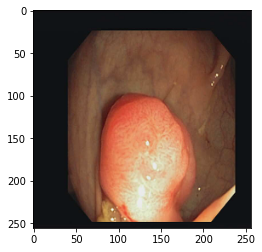

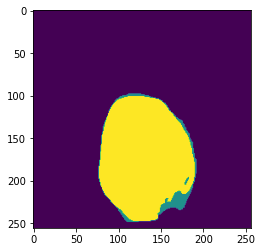

################################################################################
Original image # 0


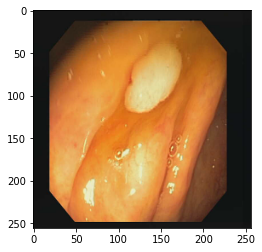

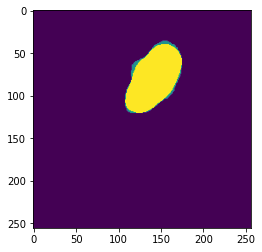

################################################################################
Original image # 1


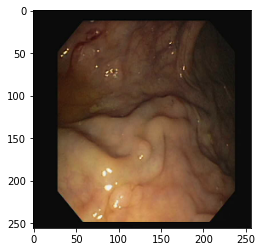

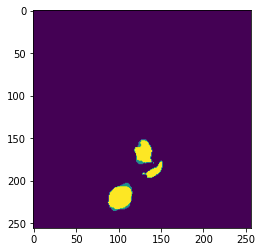

################################################################################
Original image # 2


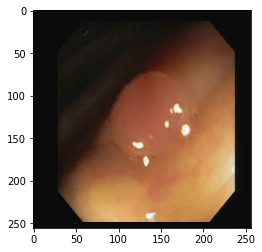

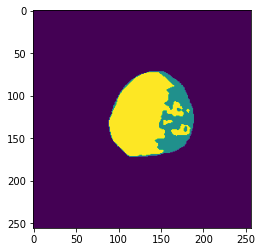

################################################################################
Original image # 3


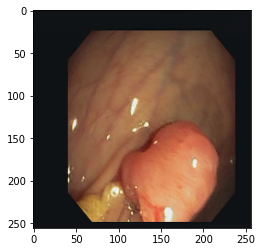

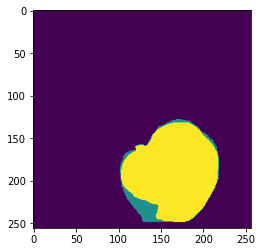

################################################################################
Original image # 4


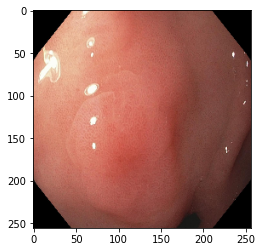

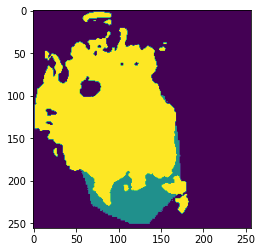

################################################################################
Original image # 5


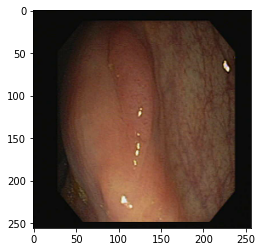

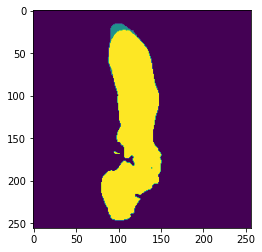

################################################################################
Original image # 6


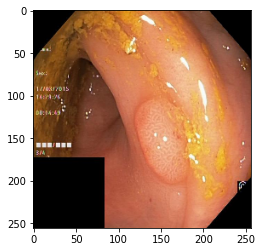

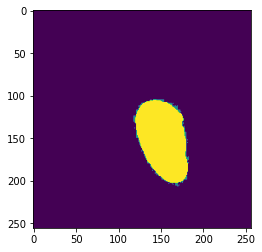

################################################################################
Original image # 7


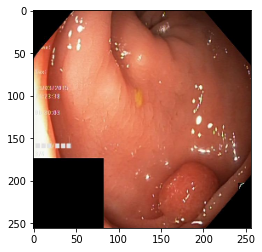

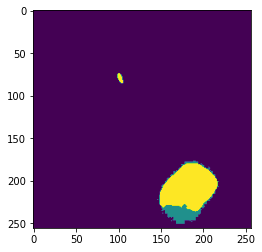

################################################################################


In [24]:
# -- Show first batch of test colonoscopy images
cont = 0
for test_batch, mask_batch in test_dataset:
  if cont < 20:
    for i, (test, mask) in enumerate(zip(test_batch, mask_batch)):
      pred = nanonet.predict(np.array([test]))
      print("Original image # {}".format(i))
      plt.imshow((test * 255).astype('uint8'))
      plt.show()
      #print("Original mask:")
      #plt.imshow(mask)
      #plt.show()
      #print("Predicted mask:")
      pred = np.round(pred[0,:,:,0])
      #plt.imshow(pred)
      #plt.show()
      pred[pred == 1] = 2
      plt.imshow(np.maximum(mask, pred))
      plt.show()
      cont+=1
      print("#"*80)
  else:
    break

In [58]:
test_pred = nanonet.predict_generator(test_dataset, verbose=1)

22/22 [==============================] - 95s 4s/step


In [59]:
real_masks = []
for _, mask in tq.tqdm(test_dataset):
  for indv_mask in mask:
    real_masks.append(indv_mask)

  0%|          | 0/22 [00:00<?, ?it/s]

In [60]:
real_masks = np.array(real_masks)

# Test IoU

In [66]:
iou(real_masks, np.squeeze(test_pred)).numpy()

0.7150401